In [498]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
import scipy.stats as stats
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import kstest
from scipy.stats import shapiro
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

In [464]:
df = pd.read_csv('Kelembapan.csv')
df['Tanggal'] = pd.to_datetime(df['Tanggal'])
df = df.rename(columns={'Kelembapan Rata-rata (%)': 'Kelembapan'})
df.set_index('Tanggal', inplace=True)
df

,Kelembapan
Tanggal,
2005-01-01,80
2005-01-02,74
2005-01-03,79
2005-01-04,82
2005-01-05,86
...,...
2007-09-26,60
2007-09-27,60
2007-09-28,62


# Plot Data

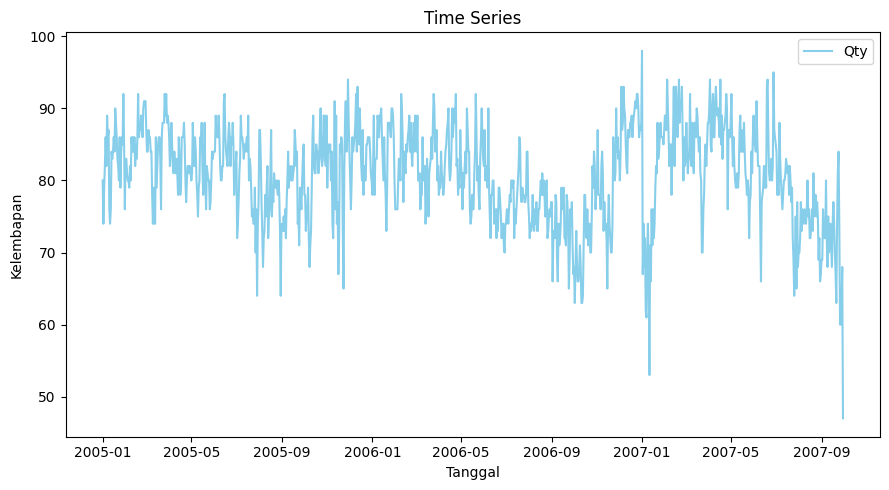

In [465]:
fig, ax = plt.subplots(figsize=(9, 5))
plt.plot(df.index, df, color='skyblue', label='Qty')
plt.xlabel('Tanggal')
plt.ylabel('Kelembapan')
plt.title('Time Series')
plt.legend()
plt.tight_layout()
plt.show()

Dapat dilihat pada plot tersebut, data yang digunakan memiliki trend naik dan turun (quadratic).

Sehingga, dapat disimpulkan bahwa data tersebut **tidak stasioner**.

# Transformasi Data Menggunakan Box Cox

Transformasi Box-Cox adalah suatu metode statistik yang digunakan untuk mengubah suatu distribusi data menjadi lebih mendekati distribusi normal.

Lambda yang digunakan untuk transformasi Box-Cox: 3.1566
Lower Confidence Limit (95%): 2.5306
Upper Confidence Limit (95%): 3.7990


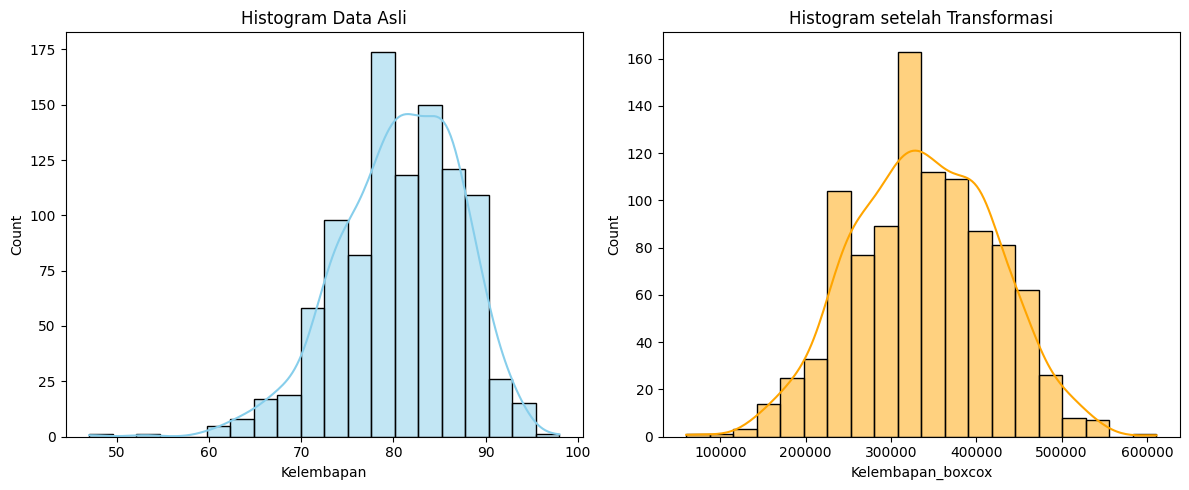

In [466]:
# Membuat salinan DataFrame
df_boxcox = df.copy()

# Nama kolom yang ingin di-transformasi (ganti 'Kelembapan' dengan nama kolom yang sesuai)
column_to_transform = 'Kelembapan'

# Box-Cox transformation
df_boxcox_vals, fitted_lambda, ci = boxcox(df_boxcox[column_to_transform], alpha=0.05)

# Menambahkan kolom hasil transformasi ke DataFrame
df_boxcox[column_to_transform+'_boxcox'] = df_boxcox_vals

# Menampilkan nilai lambda
print(f'Lambda yang digunakan untuk transformasi Box-Cox: {fitted_lambda:.4f}')

# Menampilkan confidence interval
lower_cl, upper_cl = ci
print(f'Lower Confidence Limit (95%): {lower_cl:.4f}')
print(f'Upper Confidence Limit (95%): {upper_cl:.4f}')

# Membuat subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5), tight_layout=True)

# Plot Histogram data asli
sns.histplot(df['Kelembapan'], bins=20, color='skyblue', kde=True, ax=axs[0])  # Menggunakan axs[0] untuk subplot pertama
axs[0].set_title('Histogram Data Asli')

# Plot Histogram setelah transformasi boxcox
sns.histplot(df_boxcox[column_to_transform+'_boxcox'], bins=20, color='orange', kde=True, ax=axs[1])
axs[1].set_title('Histogram setelah Transformasi')

plt.show()

Dengan tingkat kepercayaan 95%. Pada kasus ini, Confidence Interval memiliki batas bawah sekitar 2.5316 dan batas atas sekitar 3.8009. Nilai lambda yang digunakan untuk transformasi adalah sekitar 3.1581. Nilai lambda ini menunjukkan tingkat transformasi yang diterapkan pada data. Dalam hal ini, nilai lambda yang signifikan menunjukkan bahwa transformasi Box-Cox cukup kuat.

Kemudian, hasil plot histogram memvisualisasikan distribusi data sebelum dan setelah transformasi. Histogram data asli menunjukkan skewness negatif, yang dapat mengindikasikan bahwa data cenderung meratakan di sekitar nilai-nilai yang lebih tinggi. Transformasi Box-Cox berhasil mengatasi skewness ini, mengubah distribusi data menjadi lebih simetris dan mendekati distribusi normal.

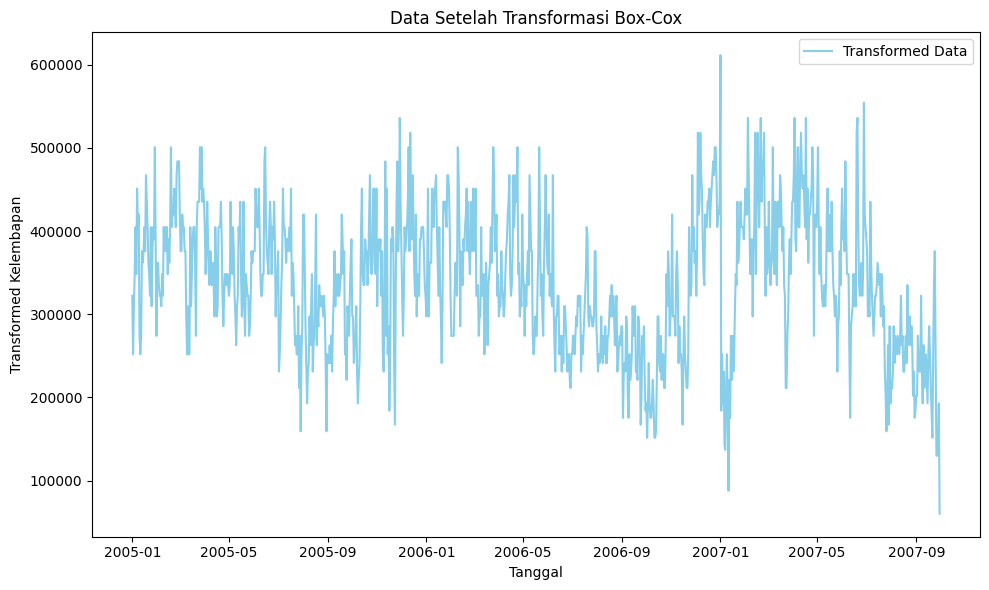

In [467]:
# Plot data setelah transformasi Box-Cox
plt.figure(figsize=(10, 6))
plt.plot(df_boxcox.index, df_boxcox[column_to_transform+'_boxcox'], color='skyblue', label='Transformed Data')
plt.xlabel('Tanggal')
plt.ylabel('Transformed Kelembapan')
plt.title('Data Setelah Transformasi Box-Cox')
plt.legend()
plt.tight_layout()
plt.show()


Setelah dilakukan transformasi menggunakan metode Box-Cox dan memvisualisasikan data melalui plot histogram, ternyata masih terlihat adanya tren pada data. Meskipun transformasi berhasil mengatasi skewness dan membuat distribusi data lebih simetris, namun karakteristik tren masih dapat terlihat. Oleh karena itu, langkah selanjutnya yang perlu diambil adalah melakukan differencing pada data untuk membuatnya menjadi stasioner.

In [468]:
# Menambahkan kolom hasil transformasi ke DataFrame
df['Transformed_'+column_to_transform] = df_boxcox_vals

# Differencing pada data yang sudah ditransformasi
df['Differenced_Transformed_'+column_to_transform] = df['Transformed_'+column_to_transform].diff().dropna()

# Menyimpan hasil differencing ke dalam DataFrame
df['differenced'] = df['Differenced_Transformed_'+column_to_transform]

# Menghilangkan nilai NaN dari kolom differencing
df.dropna(subset=['differenced'], inplace=True)

Setelah melakukan differencing pada data, langkah selanjutnya adalah memvisualisasikan hasilnya untuk memastikan bahwa data tersebut 

sudah stasioner terhadap mean dan variansinya.

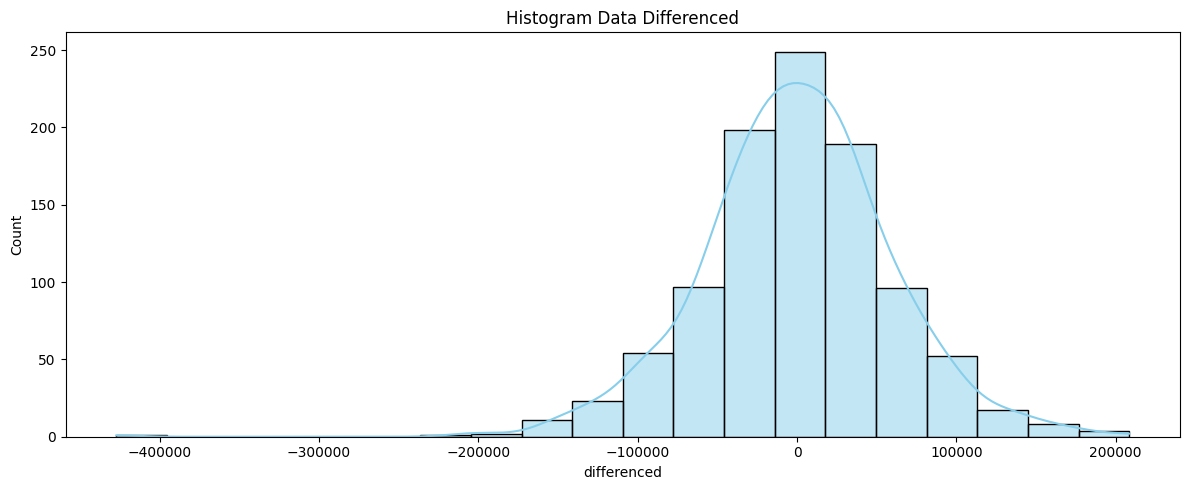

In [469]:
# Membuat subplot
fig, ax = plt.subplots(figsize=(12, 5), tight_layout=True)

# Plot Histogram data differenced
sns.histplot(df['differenced'], bins=20, color='skyblue', kde=True, ax=ax)
ax.set_title('Histogram Data Differenced')

# Menampilkan plot
plt.show()


Dari hasil plot distribusi data yang telah di-differencing, kurva distribusi menyerupai lonceng atau membentuk pola yang simetris, hal ini menunjukkan bahwa data tersebut sudah memiliki distribusi yang lebih normal. Distribusi yang normal atau simetris menandakan bahwa variabilitas (variansi) dari data cenderung konstan dan tidak mengalami perubahan signifikan.

Dengan kata lain, stasioneritas terhadap variansi telah tercapai setelah proses differencing.

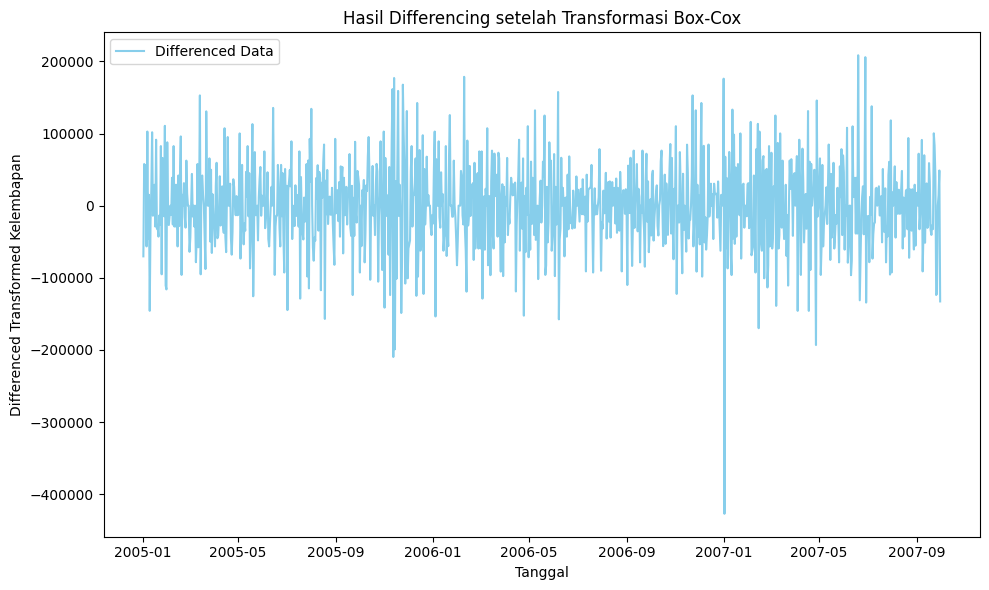

In [460]:
# Plot hasil differencing
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['differenced'], color='skyblue', label='Differenced Data')
plt.xlabel('Tanggal')
plt.ylabel('Differenced Transformed Kelembapan')
plt.title('Hasil Differencing setelah Transformasi Box-Cox')
plt.legend()
plt.tight_layout()
plt.show()


Dari hasil plot data, pola garis tengah (mean) tampak konstan atau tidak memiliki tren yang jelas sepanjang waktu, maka dapat disimpulkan bahwa data tersebut sudah stasioner terhadap mean. 

# Uji ADF

Uji Augmented Dickey-Fuller (ADF) adalah suatu metode statistik yang digunakan untuk menguji apakah suatu deret waktu stasioner atau tidak.

In [471]:
result = adfuller(df['differenced'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'\t{key}: {value}')

if result[1] <= 0.05:
  print("\nTolak H0: Data Stasioner")
else:
  print("\nTerima H0: Data Tidak Stasioner")


ADF Statistic: -12.119081467550942
p-value: 1.8431015601196997e-22
Critical Values:
	1%: -3.4369860032923145
	5%: -2.8644697838498376
	10%: -2.5683299626694422

Tolak H0: Data Stasioner


Berdasarkan hasil uji ADF tersebut, didapatkan bahwa p-value lebih kecil dari alpha (0.05) yang berarti bahwa data tersebut stasioner. Dapat kita lihat juga pada nilai kritisnya, dimana didapatkan hasil ADF statistik nya lebih kecil dari semua nilai kritis pada taraf 1%, 5%, dan 10%. Sehingga dapat disimpulkan bahwa tolak H0, yang berarti bahwa data tersebut stasioner.

# Plot ACF & PACF
$\mathrm{ACF} = \rho_k = \frac{\sum_{t=k+1}^{n}(y_t - \bar{y})(y_{t-k} - \bar{y})}{\sum_{t=1}^{n}(y_t - \bar{y})^2}$

$\mathrm{PACF} = \phi_{k,k} = \frac{\gamma_k}{\sqrt{\gamma_0 \gamma_{k,k}}}$

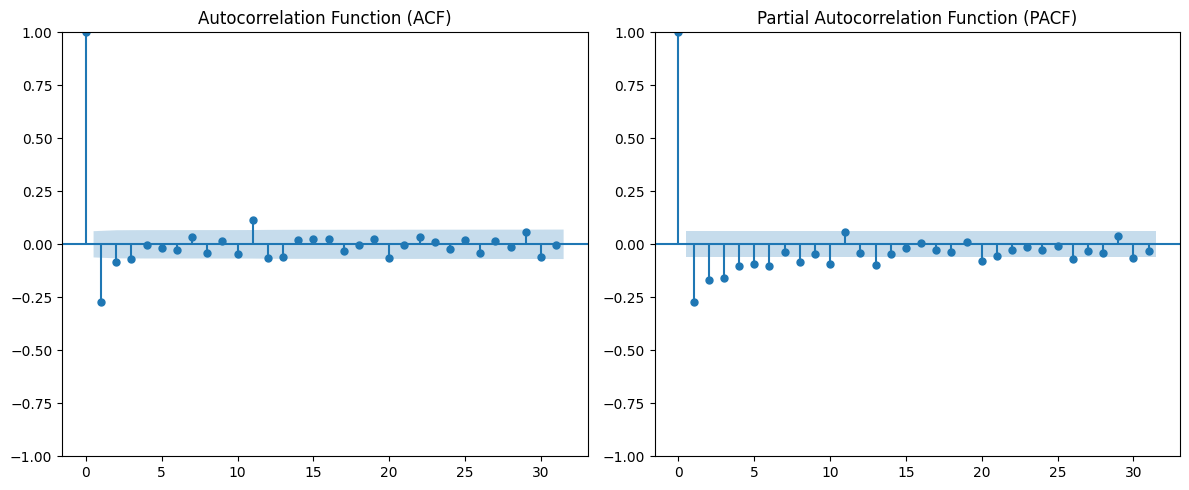

In [211]:
# Plot ACF dan PACF sejajar
fig, axs = plt.subplots(1, 2, figsize=(12, 5), tight_layout=True)

# Plot ACF
plot_acf(df['differenced'], alpha=0.05, ax=axs[0])
axs[0].set_title('Autocorrelation Function (ACF)')

# Plot PACF
plot_pacf(df['differenced'], alpha=0.05, ax=axs[1])
axs[1].set_title('Partial Autocorrelation Function (PACF)')

plt.show()


Dalam memilih lag berdasarkan plot ACF dan PACF, kita akan memilih lag dimana sebelum terjadinya cut-off.

Berikut ini adalah hasilnya :

PACF (AR) = 1, 2, 3, 11

ACF (MA) = 1, 6, 8, 10, 13, 20

# AIC

$\mathrm{AIC}=2k-2\ln\bigl(\hat{L}\bigr)$

Langkah selanjutnya adalah menentukan orde terbaik dengan melihat nilai AIC.

AIC (Akaike Information Criterion) merupakan metode yang digunakan untuk memilih model terbaik dari beberapa kombinasi model yang ada.

In [213]:
# Inisialisasi list untuk menyimpan hasil
results = []

p_values = [1, 2, 3,11]
q_values = [1, 6, 8, 10, 13, 20]

# Looping untuk setiap kombinasi p dan q
for p in p_values:
    for q in q_values:
        # Membuat model ARIMA
        model = sm.tsa.ARIMA(df['Kelembapan'], order=(p, 1, q))
        model_fit = model.fit()
        
        # Mendapatkan nilai AIC
        aic = model_fit.aic
        
        # Menyimpan hasil dalam bentuk tuple
        result_tuple = (p, 1, q, f"({p},1,{q})", aic)
        
        # Menambahkan tuple ke dalam list results
        results.append(result_tuple)

# Membuat DataFrame dari list results
columns = ['p', 'd', 'q', '(p,d,q)', 'AIC']
results_df = pd.DataFrame(results, columns=columns)

# Menampilkan DataFrame
results_df


,p,d,q,"(p,d,q)",AIC
0,1,1,1,"(1,1,1)",5762.798953
1,1,1,6,"(1,1,6)",5765.047178
2,1,1,8,"(1,1,8)",5764.525003
3,1,1,10,"(1,1,10)",5763.224039
4,1,1,13,"(1,1,13)",5758.181512
5,1,1,20,"(1,1,20)",5765.259382
6,2,1,1,"(2,1,1)",5759.531872
7,2,1,6,"(2,1,6)",5758.498576
8,2,1,8,"(2,1,8)",5760.733793
9,2,1,10,"(2,1,10)",5761.543558


 Dari semua kombinasi model yang kami gunakan, didapatkan bahwa model ARIMA(3, 1, 10) memiliki nilai AIC yang paling rendah. Sehingga model terbaik yang digunakan adalah ARIMA(3, 1, 10).

# Estimasi Patameter

In [224]:
import statsmodels.api as sm

# Pilih model terbaik
order1 = (3, 1, 10)
# Estimasi model menggunakan metode Maximum Likelihood
model1 = sm.tsa.ARIMA(df['Kelembapan'], order=order1)
results1 = model1.fit()

# Tampilkan hasil estimasi parameter
print(results1.summary())

                               SARIMAX Results                                
Dep. Variable:             Kelembapan   No. Observations:                 1002
Model:                ARIMA(3, 1, 10)   Log Likelihood               -2864.341
Date:                Sat, 30 Dec 2023   AIC                           5756.683
Time:                        11:50:32   BIC                           5825.405
Sample:                    01-02-2005   HQIC                          5782.801
                         - 09-30-2007                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1376      0.112    -10.156      0.000      -1.357      -0.918
ar.L2         -1.2301      0.073    -16.951      0.000      -1.372      -1.088
ar.L3         -0.6599      0.110     -5.979      0.0

In [492]:
# Mendapatkan koefisien, standar error, dan t-stats
coefs = results1.params
std_errs = results1.bse
t_stats = results1.tvalues

# Pilih parameter yang ingin ditampilkan
selected_params = ['ar.L3', 'ma.L10']

# Inisialisasi alpha
alpha = 0.05  

# Membuat DataFrame untuk menyimpan hasil
estimasi_df = pd.DataFrame(columns=['Parameter', 'Estimate', '|t|', 't(𝝰/2)'])

# Tampilkan hasil
for coef in selected_params:
    coef_index = coefs.index.get_loc(coef)
    t_absolute = abs(t_stats[coef_index])
    t_critical = stats.t.ppf(1 - alpha / 2, df=results1.df_resid)
    
    # Menentukan signifikansi
    signifikan = 'Ya' if t_absolute > t_critical else 'Tidak'
    
    # Simpan hasil dalam DataFrame
    df_temp = pd.DataFrame(data=[[coef, coefs[coef], t_absolute, t_critical, signifikan]],
                            columns=['Parameter', 'Estimate', '|t|', 't(𝝰/2)', 'Signifikan'])
    estimasi_df = pd.concat([estimasi_df, df_temp], ignore_index=True)

# Tampilkan DataFrame hasil
estimasi_df

,Parameter,Estimate,|t|,t(𝝰/2),Signifikan
0,ar.L3,-0.659920,5.979088,1.959964,Ya
1,ma.L10,-0.142378,4.197703,1.959964,Ya


Hasil uji signifikansi parameter menunjukkan bahwa parameter model ARIMA (3,1,10) dinyatakan signifikan dimana nilai |t| lebih besar dari t(𝝰/2).

# Uji Kelayakan Model Menggunakan LJung Box

Uji Ljung-Box merupakan salah satu metode statistik yang digunakan dalam analisis deret waktu untuk menguji apakah sisaan (residuals) dari suatu model memiliki korelasi yang signifikan pada berbagai lag waktu atau tidak. Uji ini bertujuan untuk mengevaluasi apakah model yang telah dibangun berhasil menangkap semua informasi yang ada dalam data atau masih terdapat pola atau struktur tertentu yang tidak dijelaskan oleh model.

In [496]:
# Mendapatkan residu dari model
residuals = results1.resid

# Melakukan uji Ljung-Box
lags = 20  # Jumlah lag yang ingin diuji
lb_stat, lb_p_value = acorr_ljungbox(residuals, lags=lags)

# Membersihkan data yang tidak valid
cleaned_p_value = [float(val) if val.replace('.', '', 1).isdigit() else 1.0 for val in lb_p_value]

# Menyaring hasil yang signifikan
alpha = 0.05
significant_lags = [lag for lag, p_value in enumerate(cleaned_p_value) if p_value < alpha]

if len(significant_lags) == 0:
    print("Model dinyatakan layak dan residual dapat dianggap white noise.")
else:
    print(f"Lag yang signifikan: {significant_lags}")
    print("Terdapat indikasi bahwa residual bukan white noise.")

Model dinyatakan layak dan residual dapat dianggap white noise.


In [488]:
# Mendapatkan residu dari model
residuals = results1.resid

# Melakukan uji Ljung-Box
res_acorrLjungbox = acorr_ljungbox(residuals)
test_statistic, p_val = np.mean(res_acorrLjungbox['lb_stat']), res_acorrLjungbox['lb_pvalue']

if any(p_val < 0.05):
    print('Tolak H0: Sisaan tidak bersifat white noise.')
else:
    print('Terima H0: Sisaan bersifat white noise.')

Terima H0: Sisaan bersifat white noise.


Hasil uji kelayakan menggunakan Ljung-Box pada model yang digunakan menunjukkan bahwa model layak digunakan dan sisaan (residuals) dari model tersebut bersifat white noise. Dengan kata lain, tidak terdapat korelasi yang signifikan antara nilai-nilai sisaan pada berbagai lag waktu.

# Uji Kenormalan Sisaan Menggunakan Kolmogorof-Smirnov

Uji Kolmogorov-Smirnov (KS) adalah suatu metode statistik yang digunakan untuk menguji apakah suatu sampel data mengikuti distribusi tertentu, seperti distribusi normal. Uji ini berfokus pada perbandingan antara distribusi empiris (sisaan) dari data dengan distribusi teoritis yang diasumsikan.

In [279]:
# Mendapatkan residual dari model
residuals = results1.resid

# Uji Kenormalan menggunakan Kolmogorov-Smirnov
ks_statistic, ks_p_value = kstest(residuals, 'norm')

# Menampilkan hasil uji
print(f"Kolmogorov-Smirnov Statistic: {ks_statistic}")
print(f"P-value: {ks_p_value}")

# Membuat keputusan berdasarkan p-value
alpha = 0.05
if ks_p_value < alpha:
    print(f"Tolak H0: Residual tidak berdistribusi normal")
else:
    print(f"Tidak cukup bukti untuk menolak H0: Residual berdistribusi normal")

Kolmogorov-Smirnov Statistic: 0.28901214096745353
P-value: 1.3249946129450017e-74
Tolak H0: Residual tidak berdistribusi normal


Meskipun uji Ljung-Box menyatakan bahwa model layak digunakan dan sisaan bersifat white noise, hasil uji Kolmogorov-Smirnov menunjukkan bahwa nilai Kolmogorov-Smirnov lebih besar dari P-Value yang berarti sisaan tidak berdistribusi normal. Pada uji Kolmogorov-Smirnov, nilai p-value yang sangat rendah (1.32e-74) mengindikasikan bahwa sisaan memiliki perbedaan yang signifikan dari distribusi normal. 

# Uji Kenormalan Sisaan Menggunakan Shapiro-Wilks

Uji Shapiro-Wilk adalah suatu metode statistik yang digunakan untuk menguji normalitas sebuah sampel data. Uji ini berfokus pada pengukuran sejauh mana distribusi data mendekati distribusi normal.

In [275]:
# Mendapatkan residual dari model
residuals = results1.resid

# Uji Kenormalan menggunakan Shapiro-Wilk
shapiro_statistic, shapiro_p_value = shapiro(residuals)

# Menampilkan hasil uji
print(f"Shapiro-Wilk Statistic: {shapiro_statistic}")
print(f"P-value: {shapiro_p_value}")

# Menetapkan taraf signifikansi
alpha = 0.05

# Membuat keputusan berdasarkan p-value dan taraf signifikansi
if shapiro_p_value < alpha:
    print(f"Tolak H0: Residual tidak berdistribusi normal")
else:
    print(f"Tidak cukup bukti untuk menolak H0: Residual berdistribusi normal")


Shapiro-Wilk Statistic: 0.8356672525405884
P-value: 6.720526428368635e-31
Tolak H0: Residual tidak berdistribusi normal


Nilai statistik uji Shapiro-Wilk sebesar 0.836 menunjukkan bahwa sisaan dari model tidak secara signifikan mendekati distribusi normal. Selanjutnya, nilai p-value yang sangat kecil (sekitar 6.72e-31) mengindikasikan bahwa kita memiliki cukup bukti untuk menolak hipotesis nol. Oleh karena itu, kesimpulan dari uji ini adalah bahwa sisaan tidak berdistribusi normal.

# Model ARIMA yang Digunakan

Karena dilakukan differencing pada data, maka model yang digunakan berbentuk "$W_t$"

$W_t=-1.1376  W_{t-1} + -1.2301  W_{t-2} + -0.6599  W_{t-3} +  \epsilon_t - 0.7388 \epsilon_{t-1} - 0.6322 \epsilon_{t-2} + 0.1382 \epsilon_{t-3} + 0.6529 \epsilon_{t-4} + 0.3545 \epsilon_{t-5} + 0.2168 \epsilon_{t-6} + 0.0961 \epsilon_{t-7} + 0.1372 \epsilon_{t-8} + 0.0696 \epsilon_{t-9} + 0.1424 \epsilon_{t-10}$

# Predict

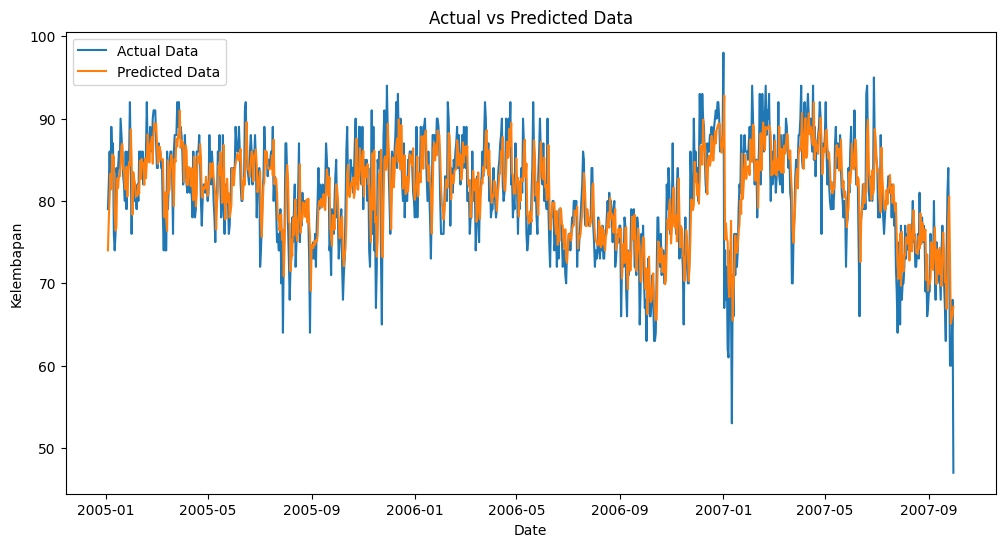

In [283]:
# Melakukan prediksi
start_index = df.index[1]
end_index = df.index[-1]
predicted_data = results1.predict(start=start_index, end=end_index)

# Visualisasi
plt.figure(figsize=(12, 6))
plt.plot(df.index[1:], df['Kelembapan'].iloc[1:], label='Actual Data') 
plt.plot(df.index[1:], predicted_data, label='Predicted Data')
plt.title('Actual vs Predicted Data')
plt.xlabel('Date')
plt.ylabel('Kelembapan')
plt.legend()
plt.show()

# Forecast

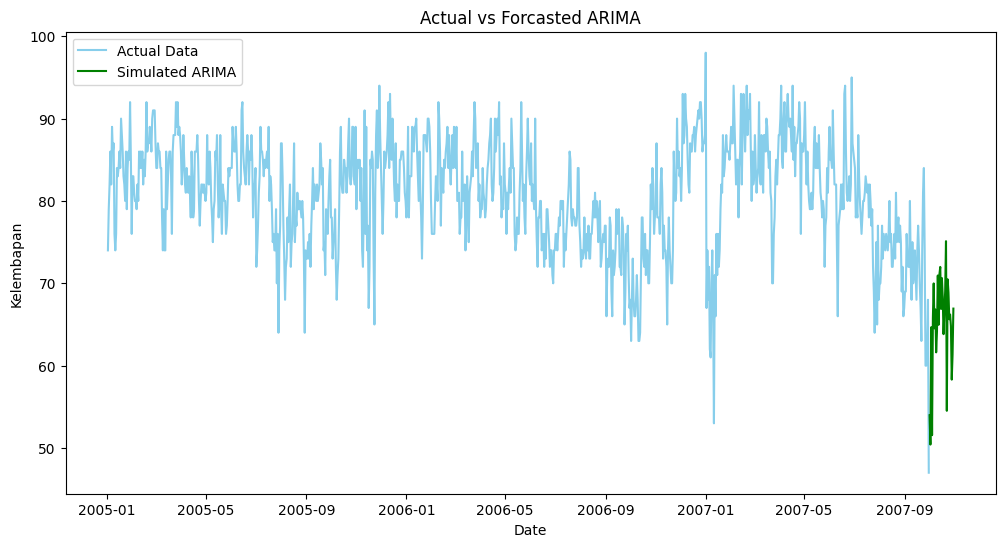

In [393]:
n_steps = 30
forecast = results1.get_forecast(steps=n_steps)
forecast_data = pd.DataFrame({'ARIMA Forecast': forecast.predicted_mean}, index=pd.date_range(start=df.index[-1], periods=n_steps+1, freq='D')[1:])

# Simulasi ARIMA
pred = results1.get_prediction(start=len(df), end=len(df) + n_steps - 1, dynamic=True)
predicted_values = pred.predicted_mean
std_errors = pred.se_mean
residuals = results1.resid
simulated_data = np.zeros(n_steps)

for i in range(n_steps):
    simulated_residual = np.random.choice(residuals, size=1)
    simulated_data[i] = predicted_values[i] + simulated_residual

forecast_data['Simulated ARIMA'] = abs(simulated_data)

# Plot prediksi ARIMA
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Kelembapan'], label='Actual Data', color='skyblue')
plt.plot(forecast_data.index, forecast_data['Simulated ARIMA'], label='Simulated ARIMA', color='green')
plt.title('Actual vs Forcasted ARIMA')
plt.xlabel('Date')
plt.ylabel('Kelembapan')
plt.legend()
plt.show()


Dari plot prediksi dan forecast, dapat disimpulkan bahwa model ARIMA(3,1,10) sudah baik dalam melakukan prediksi maupun forecast.

# Evaluasi Model dengan RMSE

In [497]:
actual_data = df['Kelembapan'].tail(30)
forecasted_data = forecast_data['ARIMA Forecast']

# Menghitung RMSE
rmse_arima = np.sqrt(mean_squared_error(actual_data, forecasted_data))

print(f"RMSE untuk ARIMA Forecast: {rmse_arima:.4f}")

RMSE untuk ARIMA Forecast: 8.4891
